In [45]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import yfinance as yf
from finta import TA

In [2]:
ticker = "BTC-USD"

btc_df = yf.download(ticker, period='2y',  index = "Date", interval = "1h")

btc_df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
2020-11-25 00:00:00,19104.410156,19159.908203,19099.224609,19124.060547,19124.060547,0
2020-11-25 01:00:00,19123.882812,19158.197266,19038.318359,19038.318359,19038.318359,0
2020-11-25 02:00:00,19038.677734,19038.677734,18900.003906,18936.783203,18936.783203,97337344
2020-11-25 03:00:00,18936.962891,18999.089844,18780.177734,18786.453125,18786.453125,29982720
2020-11-25 04:00:00,18790.531250,18869.671875,18727.464844,18727.464844,18727.464844,3701309440


### Add daily returns column

In [3]:
# Calculate the daily returns using the closing prices and the pct_change function
btc_df["actual_returns"] = btc_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
btc_df = btc_df.dropna()

# Review the DataFrame
display(btc_df.head())
display(btc_df.tail())

,Open,High,Low,Close,Adj Close,Volume,actual_returns
2020-11-25 01:00:00,19123.882812,19158.197266,19038.318359,19038.318359,19038.318359,0,-0.004483
2020-11-25 02:00:00,19038.677734,19038.677734,18900.003906,18936.783203,18936.783203,97337344,-0.005333
2020-11-25 03:00:00,18936.962891,18999.089844,18780.177734,18786.453125,18786.453125,29982720,-0.007939
2020-11-25 04:00:00,18790.531250,18869.671875,18727.464844,18727.464844,18727.464844,3701309440,-0.003140
2020-11-25 05:00:00,18723.644531,18862.431641,18664.458984,18856.312500,18856.312500,334143488,0.006880


,Open,High,Low,Close,Adj Close,Volume,actual_returns
2022-11-24 17:00:00,16618.875000,16640.017578,16597.021484,16597.021484,16597.021484,0,-0.001226
2022-11-24 18:00:00,16596.216797,16596.216797,16562.267578,16577.080078,16577.080078,0,-0.001202
2022-11-24 19:00:00,16579.537109,16585.966797,16564.498047,16571.197266,16571.197266,0,-0.000355
2022-11-25 00:00:00,16602.269531,16603.316406,16535.417969,16547.609375,16547.609375,210003968,-0.001423
2022-11-25 00:35:00,16544.486328,16544.486328,16544.486328,16544.486328,16544.486328,0,-0.000189


### Generating the Features and Target Sets

In [4]:
# Generate 3EMA with windows 50, 100, 200

short_window = 50
middle_window = 100
long_window = 200

# Create a short window EMA
btc_df["EMA50"] = btc_df["Close"].ewm(span=short_window).mean()

# Create a middle window EMA
btc_df["EMA100"] = btc_df["Close"].ewm(span=middle_window).mean()

# Create a short window EMA
btc_df["EMA200"] = btc_df["Close"].ewm(span=long_window).mean()

D:\Anaconda\envs\algotrading\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Anaconda\envs\algotrading\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
D:\Anaconda\envs\algotrading\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [5]:
# Generate RSI
btc_rsi = TA.RSI(btc_df)  

# Join RSI with the original dataframe.
btc_df = pd.concat([btc_df, btc_rsi], axis = 1)

In [6]:
# Generate Bolinger Bands
btc_bbands_df = TA.BBANDS(btc_df)

# Concatenate the Bollinger Bands to the DataFrame
btc_df = pd.concat([btc_df,btc_bbands_df], axis=1)

In [7]:
# Drop nulls & review new df
btc_df = btc_df.dropna()

btc_df.head()

,Open,High,Low,Close,Adj Close,Volume,actual_returns,EMA50,EMA100,EMA200,14 period RSI,BB_UPPER,BB_MIDDLE,BB_LOWER
2020-11-29 04:00:00,17793.132812,17843.310547,17780.669922,17781.191406,17781.191406,718780416,0.000071,17206.747734,17659.518711,17528.707236,64.415857,18080.332508,17551.505762,17022.679016
2020-11-29 05:00:00,17779.697266,17821.914062,17768.056641,17798.435547,17798.435547,170309632,0.000970,17220.848008,17647.119883,17532.928581,65.021829,18051.250231,17593.839258,17136.428284
2020-11-29 06:00:00,17797.798828,17797.798828,17728.861328,17754.179688,17754.179688,134295552,-0.002487,17233.802109,17635.293848,17536.371614,62.099057,18046.361986,17620.898438,17195.434889
2020-11-29 07:00:00,17754.025391,17896.707031,17695.884766,17892.378906,17892.378906,452956160,0.007784,17245.880391,17626.353105,17541.880763,67.076052,18042.963587,17656.801660,17270.639734
2020-11-29 08:00:00,17890.439453,18133.156250,17884.257812,18133.156250,18133.156250,551442432,0.013457,17262.484688,17620.410020,17550.980373,73.584418,18068.223813,17706.312695,17344.401578


### Create feature set

In [29]:
# Assign a copy of the sma_fast and sma_slow columns to a new DataFrame called X
X = btc_df[["EMA50", "EMA100", "EMA200", "14 period RSI", "BB_UPPER", "BB_MIDDLE", "BB_LOWER"]].copy()

# Display sample data
display(X.tail())

,EMA50,EMA100,EMA200,14 period RSI,BB_UPPER,BB_MIDDLE,BB_LOWER
2022-11-24 17:00:00,16479.666094,16272.102520,16550.075920,53.722002,16752.579629,16613.703809,16474.827988
2022-11-24 18:00:00,16487.532988,16272.342207,16550.344618,51.869441,16748.147133,16617.170215,16486.193297
2022-11-24 19:00:00,16496.768496,16272.281680,16550.552107,51.307341,16747.872241,16615.327539,16482.782837
2022-11-25 00:00:00,16504.829316,16271.961426,16550.522826,49.013787,16747.790498,16615.397070,16483.003642
2022-11-25 00:35:00,16512.322441,16271.882324,16550.462761,48.703358,16725.247321,16605.191895,16485.136468


### Create target set

In [30]:
# Create a new column in the btc_df called signal setting its value to zero.
btc_df["signal"] = 0.0

In [31]:
# Create the signal to buy
btc_df.loc[(btc_df["actual_returns"] >= 0), "signal"] = 1

In [32]:
# Create the signal to sell
btc_df.loc[(btc_df["actual_returns"] < 0), "signal"] = -1

In [33]:
# Copy the new signal column to a new Series called y.
y = btc_df["signal"].copy()

### Split the Data Into Training and Testing Datasets

In [34]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2020-11-29 04:00:00


In [35]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2021-02-28 04:00:00


In [36]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
X_train.head()

,EMA50,EMA100,EMA200,14 period RSI,BB_UPPER,BB_MIDDLE,BB_LOWER
2020-11-29 04:00:00,17206.747734,17659.518711,17528.707236,64.415857,18080.332508,17551.505762,17022.679016
2020-11-29 05:00:00,17220.848008,17647.119883,17532.928581,65.021829,18051.250231,17593.839258,17136.428284
2020-11-29 06:00:00,17233.802109,17635.293848,17536.371614,62.099057,18046.361986,17620.898438,17195.434889
2020-11-29 07:00:00,17245.880391,17626.353105,17541.880763,67.076052,18042.963587,17656.801660,17270.639734
2020-11-29 08:00:00,17262.484688,17620.410020,17550.980373,73.584418,18068.223813,17706.312695,17344.401578


In [37]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
X_test.head()

,EMA50,EMA100,EMA200,14 period RSI,BB_UPPER,BB_MIDDLE,BB_LOWER
2021-02-28 04:00:00,46779.068750,48276.271914,49330.183992,29.884812,48265.355204,46652.712109,45040.069014
2021-02-28 05:00:00,46728.796406,48225.850156,49286.241163,32.943938,48352.691151,46563.086328,44773.481505
2021-02-28 06:00:00,46680.788437,48168.806797,49239.844407,30.966477,48425.573033,46447.919727,44470.266420
2021-02-28 07:00:00,46657.026172,48105.268633,49193.505897,30.689665,48404.250116,46309.267773,44214.285431
2021-02-28 08:00:00,46631.526094,48047.306602,49151.691512,36.815827,48294.319843,46188.129687,44081.939532


### Standardizing the Data

In [38]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Incorporate the SVM Machine Learning Into the Trading Strategy

In [39]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [40]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.62      0.39      0.48      1011
         1.0       0.60      0.80      0.69      1173

    accuracy                           0.61      2184
   macro avg       0.61      0.59      0.58      2184
weighted avg       0.61      0.61      0.59      2184



### Backtesting a Machine Learning Trading Algorithm

In [41]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [42]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.61      0.43      0.51      7525
         1.0       0.56      0.72      0.63      7485

    accuracy                           0.58     15010
   macro avg       0.59      0.58      0.57     15010
weighted avg       0.59      0.58      0.57     15010



In [43]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["predicted_signal"] = testing_signal_predictions
predictions_df["actual_returns"] = btc_df["actual_returns"]
predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
2021-02-28 04:00:00,-1.0,-0.003307,0.003307
2021-02-28 05:00:00,-1.0,0.004783,-0.004783
2021-02-28 06:00:00,-1.0,-0.006469,0.006469
2021-02-28 07:00:00,-1.0,-0.000909,0.000909
2021-02-28 08:00:00,-1.0,0.009159,-0.009159


<AxesSubplot:title={'center':'SVM Trading Algorithm'}>

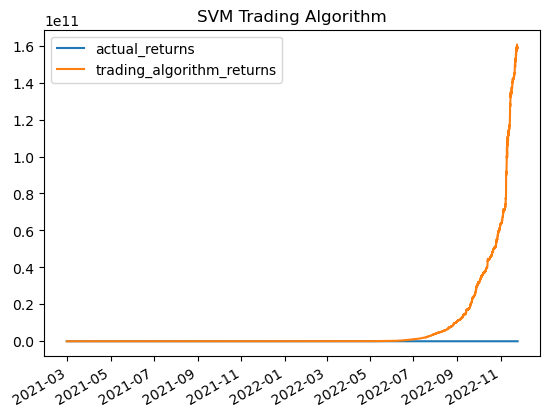

In [58]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot(title = "SVM Trading Algorithm")

### Add a Logistic Regression Model

In [46]:
# Create an instance of the LogisticRegression model
logistic_regression_model = LogisticRegression()

In [47]:
# Fit the LogisticRegression model
logistic_regression_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [48]:
# Use the trained LogisticRegression model to predict the trading signals for the training data
lr_training_signal_predictions = logistic_regression_model.predict(X_train_scaled)

# Display the predictions
lr_training_signal_predictions

array([ 1.,  1.,  1., ..., -1., -1., -1.])

In [49]:
# Generate a classification report using the training data and the logistic regression model's predications
lr_training_report = classification_report(y_train, lr_training_signal_predictions)

# Review the classification report
print(lr_training_report)

              precision    recall  f1-score   support

        -1.0       0.61      0.51      0.55      1011
         1.0       0.63      0.71      0.67      1173

    accuracy                           0.62      2184
   macro avg       0.62      0.61      0.61      2184
weighted avg       0.62      0.62      0.62      2184



In [52]:
# Use the trained model to predict the trading signals for the testing data.
lr_testing_signal_predictions = logistic_regression_model.predict(X_test_scaled)

In [53]:
# Generate a classification report using the testing data and the logistic regression model's predictions
lr_testing_report = classification_report(y_test, lr_testing_signal_predictions)

# Review the testing classification report
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       0.60      0.60      0.60      7525
         1.0       0.60      0.60      0.60      7485

    accuracy                           0.60     15010
   macro avg       0.60      0.60      0.60     15010
weighted avg       0.60      0.60      0.60     15010



In [54]:
# Create a new empty predictions DataFrame using code provided below.
lr_predictions_df = pd.DataFrame(index=X_test.index)
lr_predictions_df["predicted_signal"] = lr_testing_signal_predictions
lr_predictions_df["actual_returns"] = btc_df["actual_returns"]
lr_predictions_df["trading_algorithm_returns"] = lr_predictions_df["actual_returns"] * lr_predictions_df["predicted_signal"]
lr_predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
2021-02-28 04:00:00,-1.0,-0.003307,0.003307
2021-02-28 05:00:00,-1.0,0.004783,-0.004783
2021-02-28 06:00:00,-1.0,-0.006469,0.006469
2021-02-28 07:00:00,-1.0,-0.000909,0.000909
2021-02-28 08:00:00,-1.0,0.009159,-0.009159


<AxesSubplot:title={'center':'Logistic Regression Trading Algorithm'}>

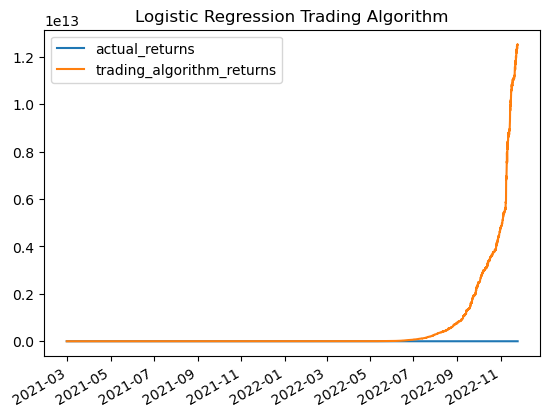

In [62]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + lr_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot(title = "Logistic Regression Trading Algorithm")

## Compare the performance of the logistic regression and SVM models using the classification reports generated with the testing data. 

In [56]:
# Print the classification report for the Logistic Regression model using the test data
print("Logistic Regression Classification Report")
print(lr_testing_report)

Logistic Regression Classification Report
              precision    recall  f1-score   support

        -1.0       0.60      0.60      0.60      7525
         1.0       0.60      0.60      0.60      7485

    accuracy                           0.60     15010
   macro avg       0.60      0.60      0.60     15010
weighted avg       0.60      0.60      0.60     15010



In [57]:
# Print the classification report for the SVM model using the test data
print("SVM Classification Report")
print(svm_testing_report)

SVM Classification Report
              precision    recall  f1-score   support

        -1.0       0.61      0.43      0.51      7525
         1.0       0.56      0.72      0.63      7485

    accuracy                           0.58     15010
   macro avg       0.59      0.58      0.57     15010
weighted avg       0.59      0.58      0.57     15010



The logistic regression model has a slightly better accuracy score over the SVM model. It also has the exact same value for precision and recall across both the buy (1) and sell (-1) signals. Due to these reasons you could say the logistic regression model is a better classifier than the SVM, although the SVM trading algorithm returns outperforms the logistic trading algorithm returns by 40%.
